# Yelp: User and Review Analysis

In [1]:
!spark-shell --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.1.1
      /_/
                        
Using Scala version 2.12.13, OpenJDK 64-Bit Server VM, 1.8.0_292
Branch HEAD
Compiled by user  on 2021-06-23T22:10:53Z
Revision e9c1449899ac58a10ea28ca6f1e8ed6c7c254d54
Url https://bigdataoss-internal.googlesource.com/third_party/apache/spark
Type --help for more information.


<details>
<summary><b>Table of Contents</b> (click to open)</summary>
<!-- MarkdownTOC -->

1. [User Stickiness](#stickiness)
1. [User Influence](#influence)
1. [Bias in Online Reviews](#bias)
1. [State with most Reviewers](#reviewers)
1. [Trend of user activity](#activity)
<!-- /MarkdownTOC -->
</details>

### Import Libraries

In [2]:
import seaborn as sns
import folium
import numpy as np
import matplotlib.pyplot as plt

import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.sql import Window

In [3]:
font_size = 16
params = {"axes.titlesize": font_size,
          "axes.labelsize": font_size*.7,
          "xtick.labelsize": font_size*.5,
          "ytick.labelsize": font_size*.5,
          "legend.fontsize": font_size*.5,
          "figure.figsize": (20, 10),
          "axes.titlepad": 25}

plt.style.use('seaborn-darkgrid')
sns.set_context("notebook", rc=params)

## Load Data

Load the review data from google cloud storage to dataproc

In [4]:
file_review = "gs://proj-spark/yelp-dataset/yelp_academic_dataset_review.json"
file_business = "gs://proj-spark/yelp-dataset/yelp_academic_dataset_business.json"
file_users = "gs://proj-spark/yelp-dataset/yelp_academic_dataset_user.json"
file_checkin = "gs://proj-spark/yelp-dataset/yelp_academic_dataset_checkin.json"
file_tip = "gs://proj-spark/yelp-dataset/yelp_academic_dataset_tip.json"

In [5]:
df_review = spark.read.format('json').load(file_review)
df_review.createOrReplaceTempView('reviewTable')

df_business = spark.read.format('json').load(file_business)
df_business.createOrReplaceTempView('businessTable')

df_users = spark.read.format('json').load(file_users)
df_users.createOrReplaceTempView('usersTable')

df_checkin = spark.read.format('json').load(file_checkin)
df_checkin.createOrReplaceTempView('checkinTable')

df_tip = spark.read.format('json').load(file_tip)
df_tip.createOrReplaceTempView('tipTable')

## User Stickiness <a class="anchor" id="stickiness"></a>

Since how many years have users been using yelp?

In [6]:
df_stickiness = df_users.withColumn('yelping_since', F.to_date('yelping_since','yyyy-MM-dd HH:mm:ss'))\
    .withColumn('#Years', F.lit(F.year(F.current_date())) - F.year('yelping_since'))\
    .groupBy('#Years')\
    .agg(F.count('user_id').alias("#Users"))\
    .orderBy('#Years')

# percentage of users yelping since #Years
df_stickiness = df_stickiness.withColumn('pert', 100*col('#Users')/F.sum("#Users").over(Window.partitionBy()))

Text(0.5, 1.0, 'User Stickiness')

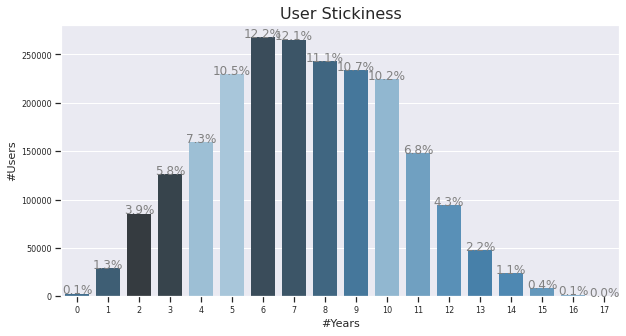

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
stickiness = df_stickiness.toPandas()
rank = stickiness['#Users'].rank(method='dense').astype(int)-1
palette = np.array(sns.color_palette("Blues_d", len(stickiness)))[rank]

ax = sns.barplot(x='#Years', y='#Users', data=stickiness, ax=ax, palette=palette)

# display percentage 
for idx, row in stickiness.iterrows():
    ax.text(row['#Years'], row['#Users'], '{:.1f}%'.format(row['pert']), color='gray', ha="center")
    
ax.set_title('User Stickiness')

## User Influence <a class="anchor" id="influence"></a>

In [8]:
top = 10

# Top 10 active users
df_active = df_users.orderBy(F.desc('review_count')).limit(top)

# Top 10 social users (based on number of friends)
df_social = df_users.withColumn('no_of_friends', F.size(F.split('friends',', ')))\
    .orderBy(F.desc('no_of_friends'))\
    .limit(top)

# Top 10 popular users (based on number of fans)
df_popular = df_users.orderBy(F.desc('fans')).limit(top)

# Top 10 effective users (based on number of userful reviews)
df_effective = df_users.orderBy(F.desc('useful')).limit(top)

Plot user influence

Text(0.5, 1.0, 'Top Effective')

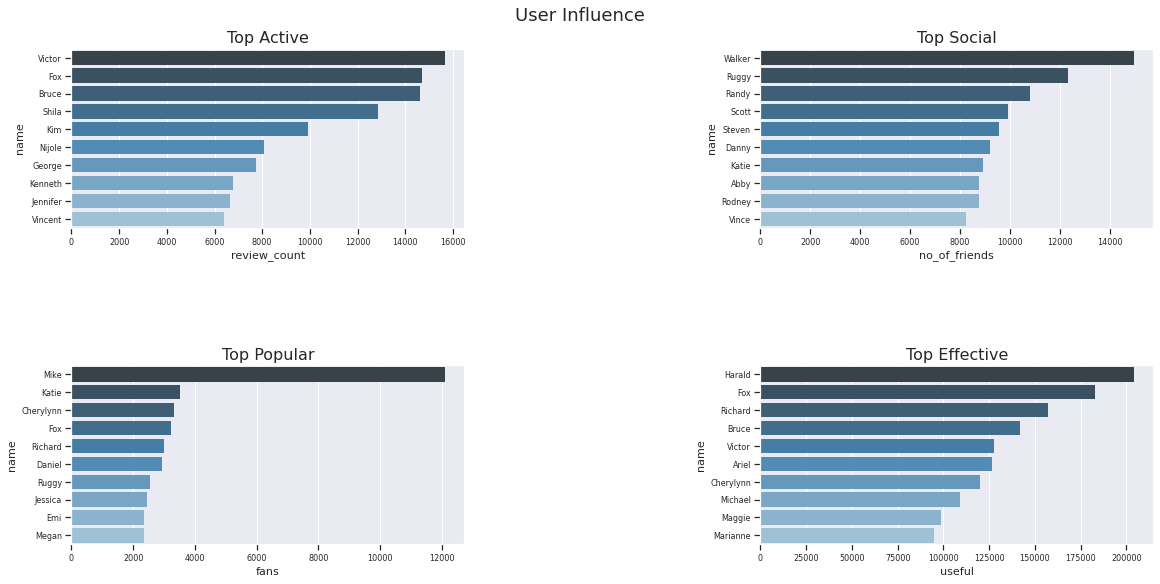

In [9]:
# figure and grid for ploting
fig = plt.figure(figsize=(16, 8), constrained_layout=True)
grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3, figure=fig)
fig.suptitle('User Influence', fontsize=18)
palette = np.array(sns.color_palette("Blues_d", 10))[::-1]

# Active users
data_active = df_active.toPandas()
ax = plt.subplot(grid[0, 0])
ax = sns.barplot(x='review_count', y='name', data=data_active, ax=ax, palette=palette)
ax.set_title('Top Active')

# Social Users
data_social = df_social.toPandas()
ax = plt.subplot(grid[0, 1])
ax = sns.barplot(x='no_of_friends', y='name', data=data_social, ax=ax, palette=palette)
ax.set_title('Top Social')

# Popular Users
data_popular = df_popular.toPandas()
ax = plt.subplot(grid[1, 0])
ax = sns.barplot(x='fans', y='name', data=data_popular, ax=ax, palette=palette)
ax.set_title('Top Popular')

# Effective Users
data_effective = df_effective.toPandas()
ax = plt.subplot(grid[1, 1])
ax = sns.barplot(x='useful', y='name', data=data_effective, ax=ax, palette=palette)
ax.set_title('Top Effective')

## Bias in Online Reviews <a class="anchor" id="bias"></a>

Is it true that people who write a review are those who are more dissatisfied or more satisfied with the service provided by business?

Transformation for average stars per business

In [10]:
df_stars = df_review.groupBy('business_id').agg(F.avg(col('stars')).alias('avg_stars'))

Join business dataframe with df_stars by business_id.

In [11]:
joinExpression = df_business["business_id"] == df_stars['business_id']
df_business_star = df_business.join(df_stars, joinExpression, 'left_outer')\
    .drop(df_stars["business_id"])

In [12]:
df_business_star.select('business_id', 'name', 'city', 'stars', 'avg_stars').limit(3).show()

+--------------------+--------------------+-------+-----+------------------+
|         business_id|                name|   city|stars|         avg_stars|
+--------------------+--------------------+-------+-----+------------------+
|A7BjX9tmAQvnJto9Z...|Briarcliff Dental...|Atlanta|  4.5| 4.421052631578948|
|cyvpFpmpN0YgDykuO...|Pandolfino's Hair...| Natick|  4.5| 4.533333333333333|
|mvEzzcqpiK5w5F80F...|           Starbucks| Boston|  3.0|2.7450980392156863|
+--------------------+--------------------+-------+-----+------------------+



Plot Histogram for rating deviation between the avg_stars accumulated from written reviews and the actual star rating of a business (ie: the average of stars given by reviewers who wrote an actual review and reviewers who just provided a star rating).

In [13]:
df_dev = df_business_star\
    .selectExpr("(coalesce(avg_stars, 0) - coalesce(stars, 0))/coalesce(stars, 1) AS deviation")

Text(0.5, 1.0, 'Histogram of rating deviation')

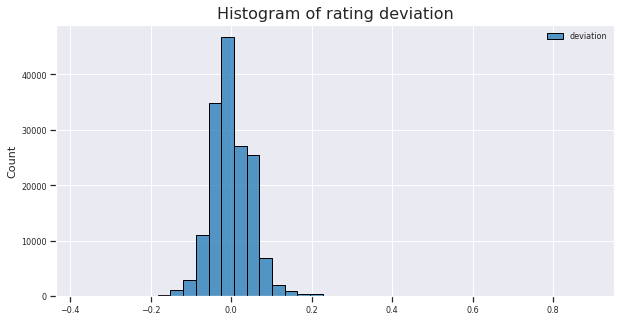

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
deviation = df_dev.toPandas()
ax = sns.histplot(deviation, bins=40, ax=ax)
ax.set_title('Histogram of rating deviation') 

In [15]:
print('Mean:{} and Std: {}'.format(deviation.deviation.mean(), deviation.deviation.std()))

Mean:0.0011443037144630323 and Std: 0.05142371949844016


Note: Distribution is like a normal distribution and the variance is quite small. Thus, it is unlikely that people who write a review are those who are more dissatisfied or more satisfied with the service provided by businesses. If distribution were positively skewed then reviewers who left a written response were more satisfied than others. If distribution were negatively skewed then they are more dissatisfied than others.

## State with most Reviewers <a class="anchor" id="reviewers"></a>

In [16]:
# Number of Reviewers for each business
df_reviewers_cnt = df_review.groupBy('business_id')\
    .agg(F.countDistinct('user_id').alias('#Reviewers'))

# Number of Reivewers for each state
joinExpression = df_business['business_id'] == df_reviewers_cnt['business_id']
df_state_reviewers = df_business.join(df_reviewers_cnt, joinExpression, 'left_outer')\
    .groupBy('state')\
    .agg(F.sum('#Reviewers').alias('#Reviewers'))\
    .orderBy(F.desc('#Reviewers'))

Plot number of reviewers for top-5 state

Text(0.5, 1.0, 'Top-5 State with most Reviewers')

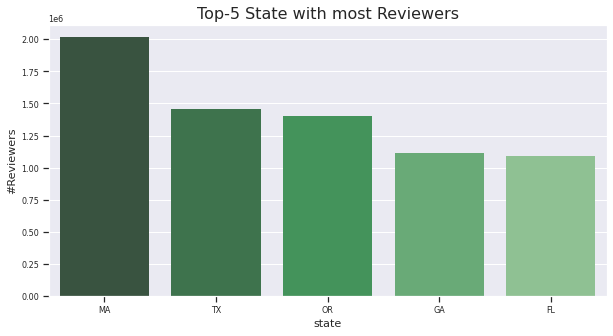

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
state_data = df_state_reviewers.limit(5).toPandas()
rank = state_data['#Reviewers'].rank(method='dense').astype(int) - 1
palette = np.array(sns.color_palette("Greens_d", len(state_data)))[rank]
ax = sns.barplot(x='state', y='#Reviewers', data=state_data, ax=ax, palette=palette)
ax.set_title('Top-5 State with most Reviewers')

##  Trend of user activity <a class="anchor" id="activity"></a>

In [33]:
df_review2 = df_review.withColumn('date', F.to_date('date', 'yyyy-MM-dd HH:mm:ss'))\
    .withColumn('year', F.year('date'))\
    .withColumn('month', F.month('date'))\
    .withColumn('day', F.dayofmonth('date'))\
    .sample(withReplacement=False, fraction=0.0001, seed=2020)

In [35]:
data = df_review2.toPandas()

Text(0.5, 1.0, 'Yearly User Activity')

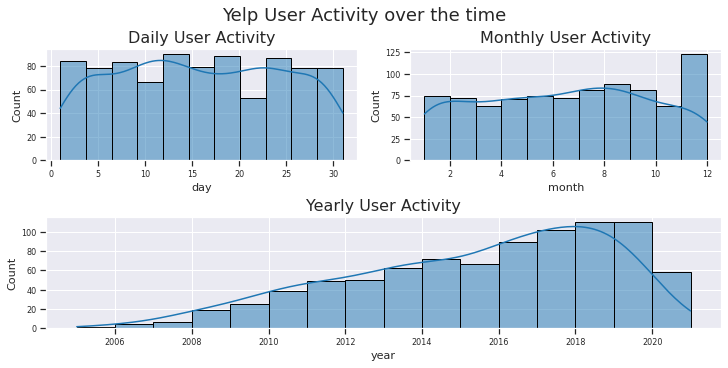

In [36]:
fig = plt.figure(figsize=(10,5), constrained_layout=True)
grid = plt.GridSpec(2,2, figure=fig)
fig.suptitle('Yelp User Activity over the time', fontsize=18)

ax = plt.subplot(grid[0,0])
ax = sns.histplot(x='day', kde=True, data=data, ax=ax)
ax.set_title('Daily User Activity')

ax = plt.subplot(grid[0,1])
ax = sns.histplot(x='month', kde=True, data=data, ax=ax)
ax.set_title('Monthly User Activity')

ax = plt.subplot(grid[1,:])
ax = sns.histplot(x='year', kde=True, data=data, ax=ax)
ax.set_title('Yearly User Activity')